In [1]:
# NN for age prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv('/Users/krishshah/Desktop/Krish_Sky_Long_AI/spine_texture_analysis.csv')
print(df.head())

   age sex  texture_score  edge_score  shape_score
0    6   F       5.428603    0.796251     4.701439
1   10   F       5.569553    0.583567     5.067939
2   13   F       5.452931    0.719179     4.386277
3   25   F       4.322031    0.330064     4.552385
4   31   F       5.805200    0.748549     4.920593


In [3]:
# dataframe cleaning
df = df.dropna()  # Drop rows with missing values
df = df[df['sex'] == 'F']  # Remove rows with non-positive ages
df['age'] = df['age']//5
df.drop(columns=['sex'], inplace=True)
df

,age,texture_score,edge_score,shape_score
0,1,5.428603,0.796251,4.701439
1,2,5.569553,0.583567,5.067939
2,2,5.452931,0.719179,4.386277
3,5,4.322031,0.330064,4.552385
4,6,5.805200,0.748549,4.920593
5,7,6.199163,0.342327,5.128160
6,7,4.277627,0.114491,5.118457
7,12,4.546191,0.126566,5.264554
8,15,4.763363,0.207147,4.971540


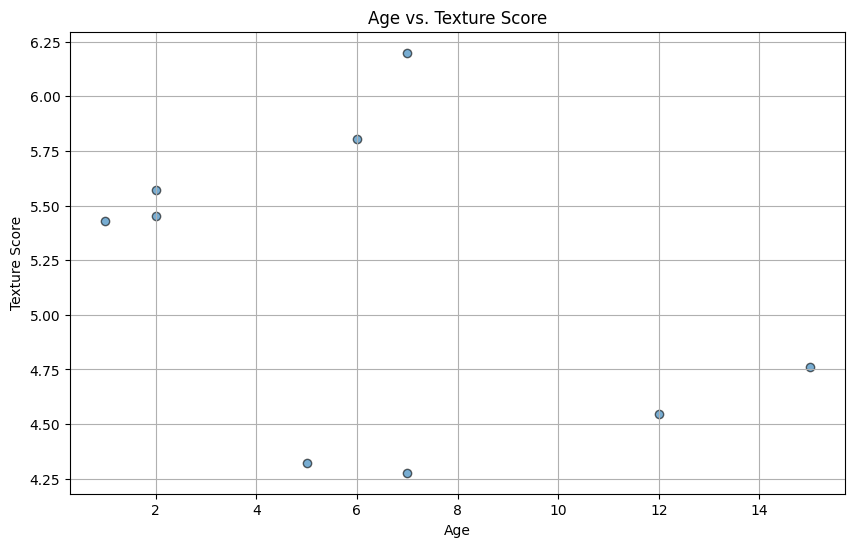

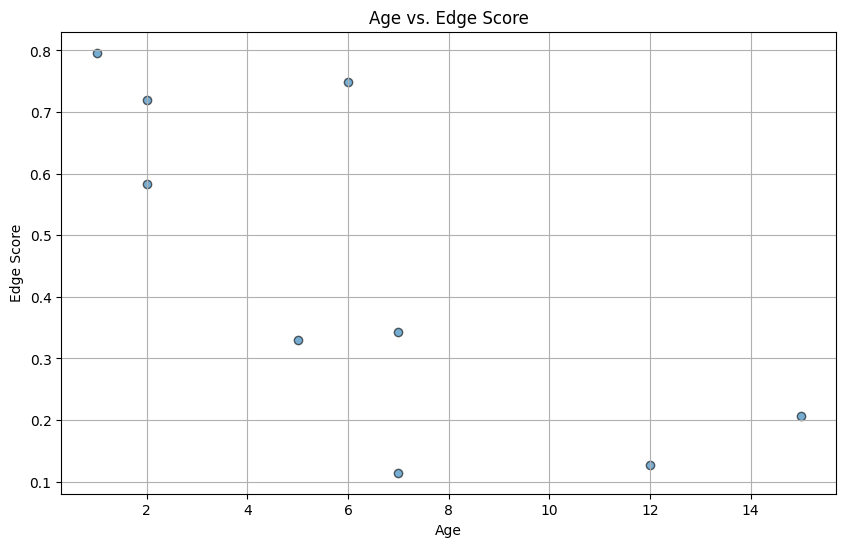

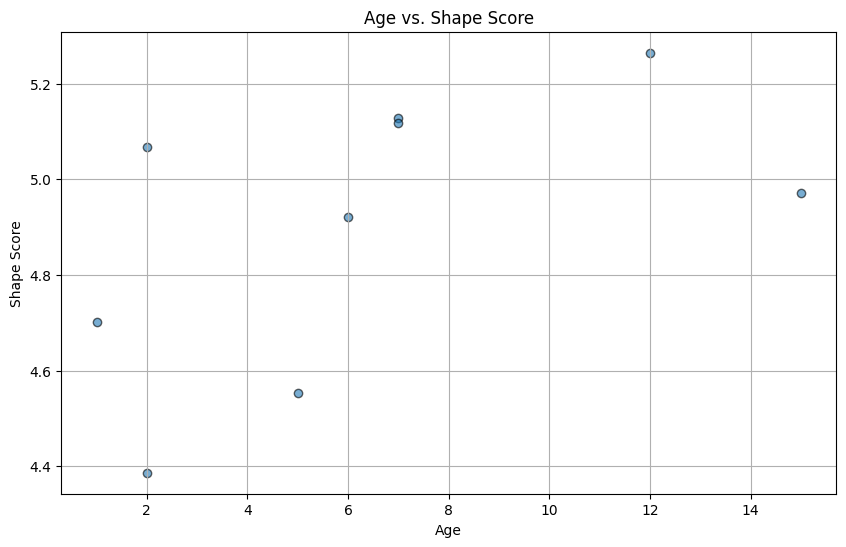

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['texture_score'], alpha=0.6, edgecolors='k')
plt.title('Age vs. Texture Score')
plt.xlabel('Age')
plt.ylabel('Texture Score')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['edge_score'], alpha=0.6, edgecolors='k')
plt.title('Age vs. Edge Score')
plt.xlabel('Age')
plt.ylabel('Edge Score')
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df['age'], df['shape_score'], alpha=0.6, edgecolors='k')
plt.title('Age vs. Shape Score')
plt.xlabel('Age')
plt.ylabel('Shape Score')
plt.grid()
plt.show()

In [5]:
class Model(nn.Module):
  # input layer contains 3 inputs of the model
  # 1st hidden layer (l1) will have 20 neurons
  # 2nd hidden layer (l2) will have 20 neurons
  # 3rd hidden layer (l3) will have 20 neurons
  # output layer has 20 neurons to pick a seed class

  def __init__(self, in_features=3, L1=20, L2=20, L3=20, out_features=20):
    super().__init__() # inherites from the superclass (nn.Module)
    self.fc1 = nn.Linear(in_features, L1) #fc1 = fully connected
    self.fc2 = nn.Linear(L1, L2) # stars with input features, moving FORWARD to the next stage
    self.fc3 = nn.Linear(L2, L3) # stars with input features, moving FORWARD to the next stage
    self.out = nn.Linear(L3, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x)) # relu = rectified linear unit. If output<0, it is 0. if >0, then use the output
    x = F.relu(self.fc2(x)) # moves the object forward
    x = F.relu(self.fc3(x)) # moves the object forward
    x = F.relu(self.out(x))

In [6]:
# Create random seed for randomisation
torch.manual_seed(41)
model = Model() # creates an instance of the Model class

In [7]:
#train, test, split: set features (X) and targets (y)
X = df.drop('age', axis = 1) # selects only the targets, axis (columns)
y = df['age']

#convert to numpy arrays
X = X.values
y = y.values

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41) #80% train, 20% test

In [9]:
X_train = torch.FloatTensor(X_train) # converts numpy arrays to floatTensors (all features are decimals)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) # converts numpy arrays to longTensors (all targets are integers)
y_test = torch.LongTensor(y_test)

In [10]:
# set a criterion of the model to measure the error, to measure how far off the predictions are from the actual data
criterion = nn.CrossEntropyLoss()
# choose an optimiser - using Adam optimiser, lr (learning rate) = if learning rate does not go down through each iteration, it should be lowered to learn slower
optimiser = torch.optim.Adam(model.parameters(), lr=0.01) # lower learning rate takes longer to train the model
#model.parameters() are the layers: fc1, fc2, fc3, out

In [11]:
# Train model, determining how many epochs needed. Epoch = 1 run through the entire network
epoch = 1000
losses = [] # to keep track of the losses to track progress
for i in range(epoch):
  # Go forward and get prediciton
  y_pred = model.forward(X_train) # using the features to move forward and get predicitive results

  # Measure the loss
  loss = criterion(y_pred, y_train) # predicted value vs y-train value
  losses.append(loss.detach().numpy())

  if i % 100 == 0:
    print(f'{epoch}: {i} and the loss is {loss}')

  # Back propogation = take the error rate of the forward propogation and feed it back through the neural network to tweak the weights
  optimiser.zero_grad() # Clears the old gradient values, ensuring gradients from the previous iterations don’t accumulate.
  loss.backward() # Performs backpropagation to calculate the new gradients of the loss with respect to each parameter (weights)
  optimiser.step() # Uses the calculated gradients to update the model's parameters, moving them toward values that minimize the loss

TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not NoneType

In [ ]:
plt.plot(range(epoch), losses) # y-axis = losses
plt.ylabel("Loss/error")
plt.xlabel("Epoch")
plt.show()

In [ ]:
# Evaluate deep learning results on our test data
with torch.no_grad():
   #turns off back propogation
   y_eval = model.forward(X_test) # testing the model on the new dataset, features from test set on predictions
   loss = criterion(y_eval, y_test) # find the loss error

In [ ]:
loss

In [ ]:
correct = 0
diff = []
with torch.no_grad():
  for i, data in enumerate(X_test): #features test set
    y_val = model.forward(data) #outcome of testing

    # tells us what type of flower out network thinks it is

    print(f'{i+1}.) {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}') # compares feature test to target test

    # correct or not
    if y_val.argmax().item() == y_test[i]: # if the index of the max tensor in the feature test == target test value
      correct +=1

    x = abs((y_val.argmax().item() - y_test[i]))
    diff.append(x)

print(f'We got {correct} correct!. Accuracy: {correct}/{len(y_test)} ({((correct/y_test.size(0))*100):.2f}%)')
print(f'The mean difference between predicted and actual quality: {sum(diff) / len(diff):.4f}')